In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 4
BETA = 2.0
LAMBDA = 0.01  # Regularization weight

def compute_fisher_information(model, dataloader, device):
    model.eval()
    fisher_information = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            fisher_information[name] = torch.zeros_like(param, device=device)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if "weight" in name and param.grad is not None:
                fisher_information[name] += (param.grad ** 2)
        break

    return fisher_information

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

# Compute Fisher Information
fisher_information = compute_fisher_information(model, train_loader, device)

100%|██████████| 170M/170M [00:02<00:00, 60.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-2-1e0636034fab>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


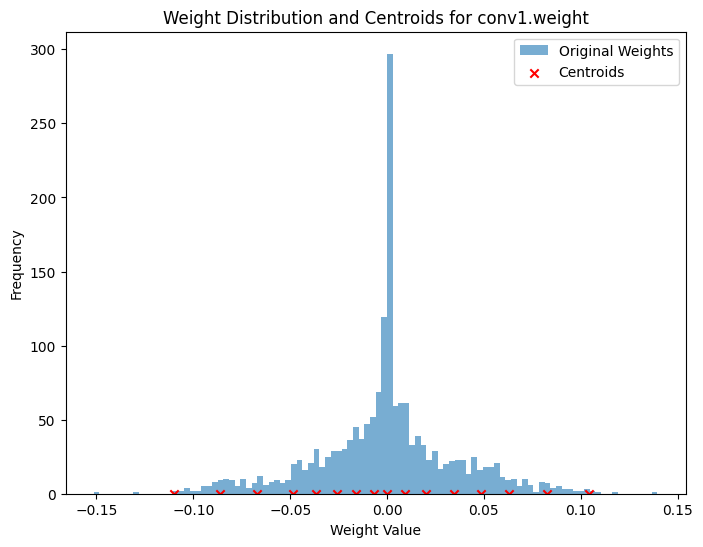

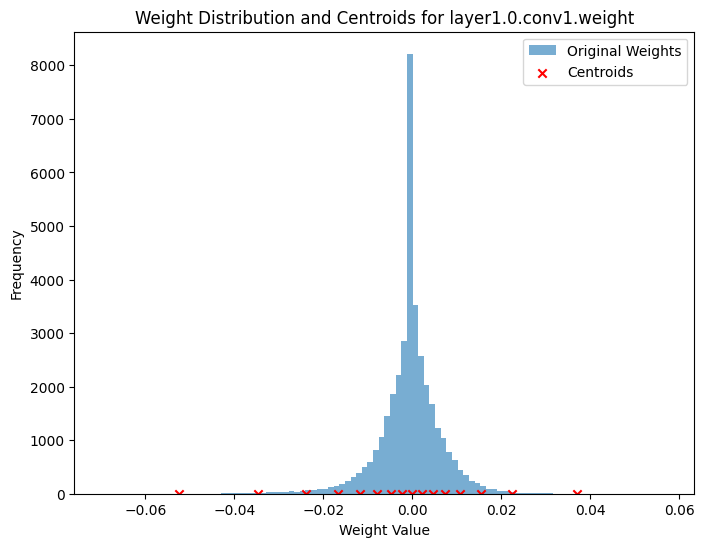

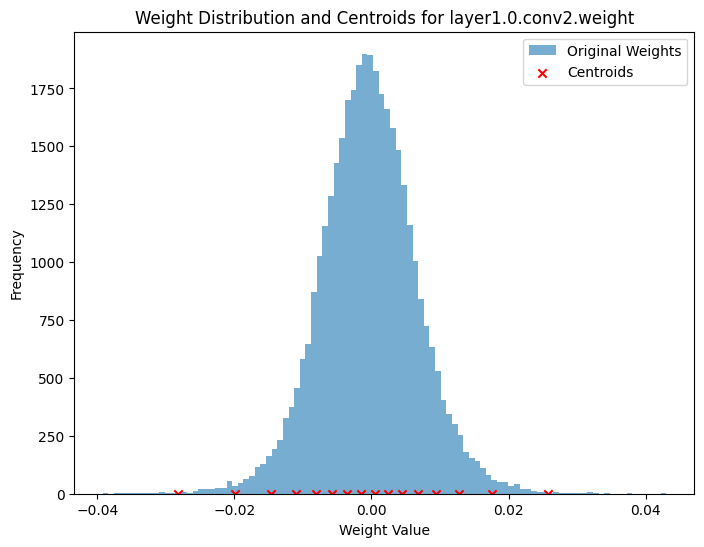

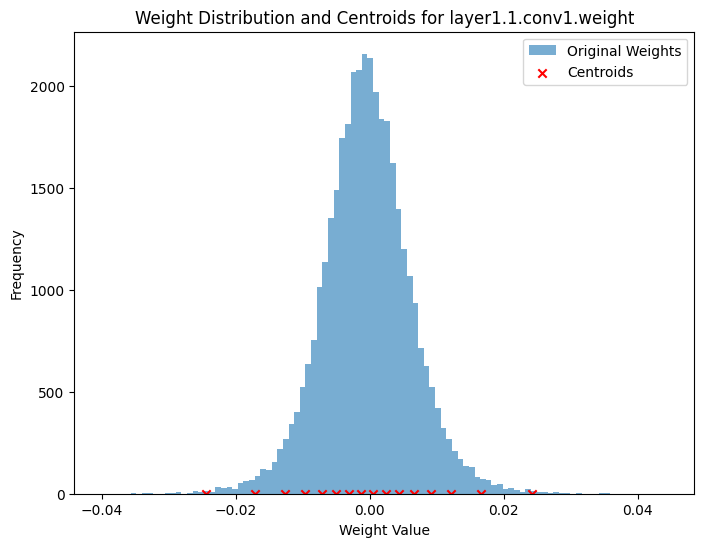

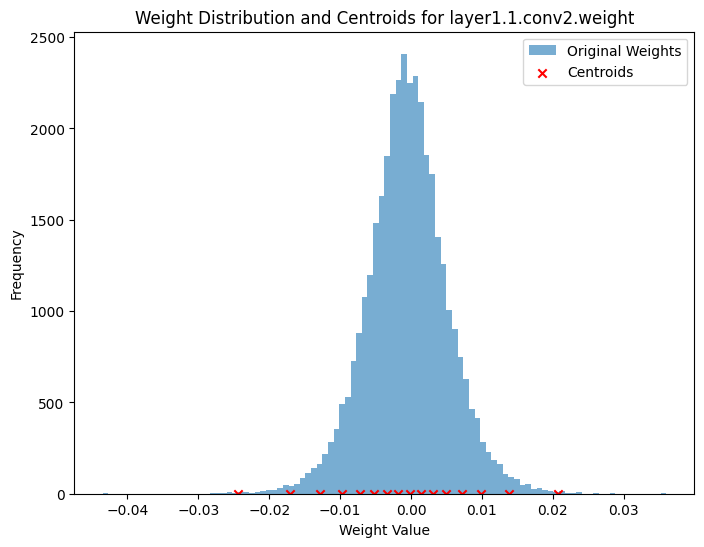

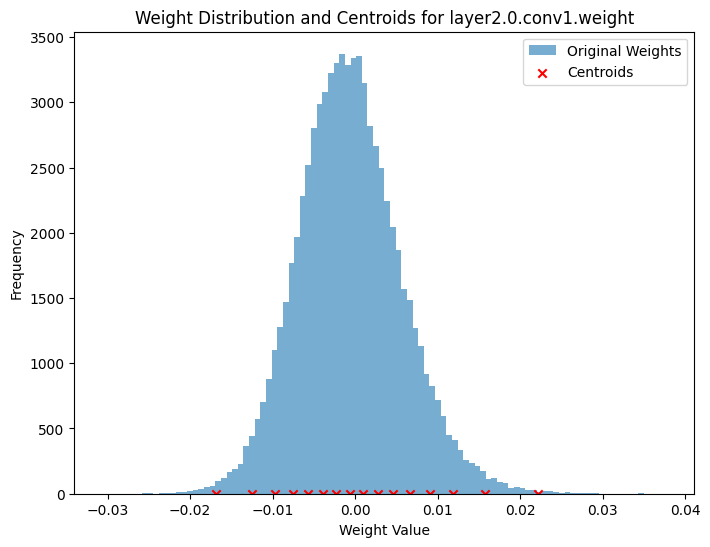

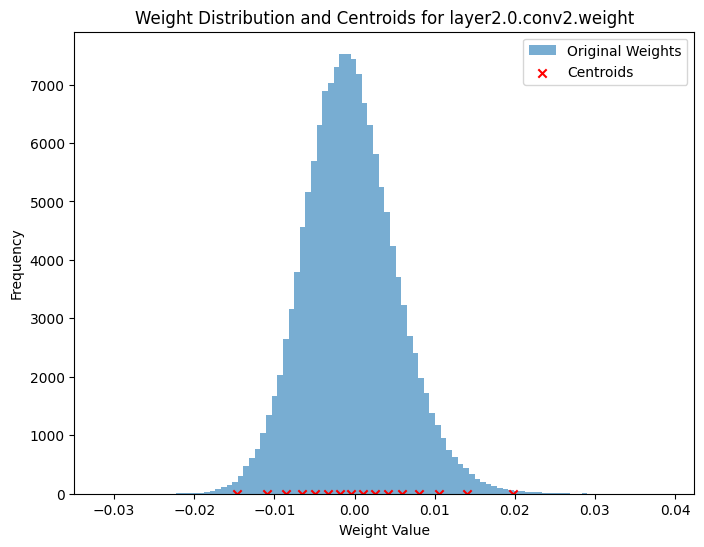

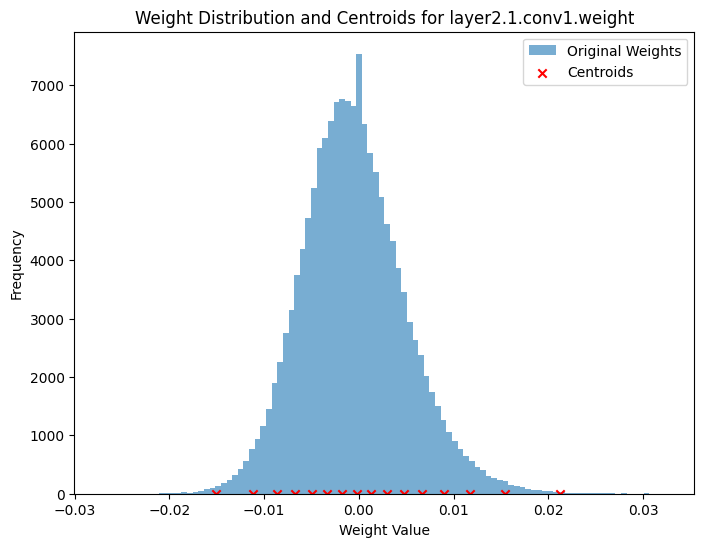

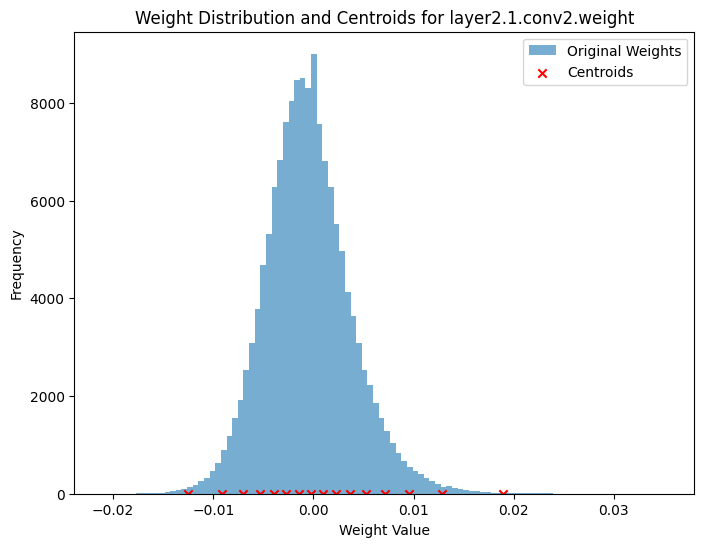

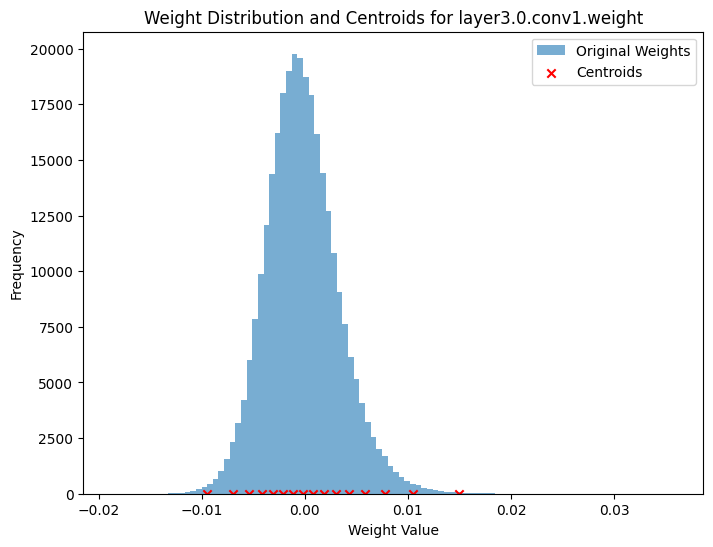

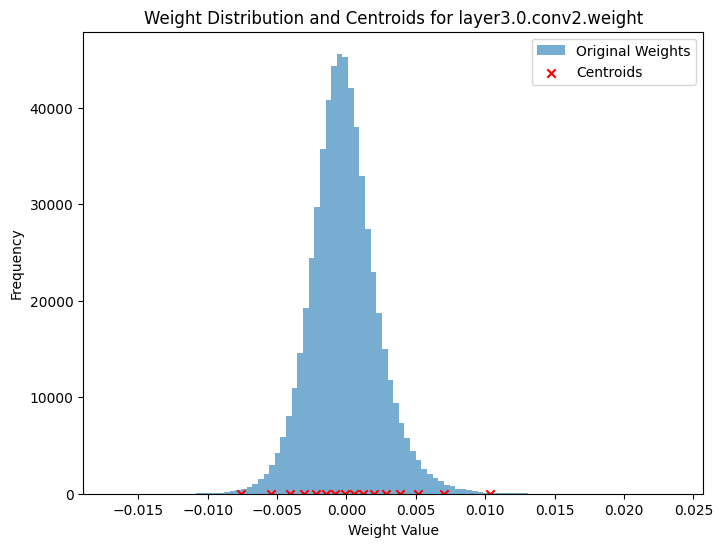

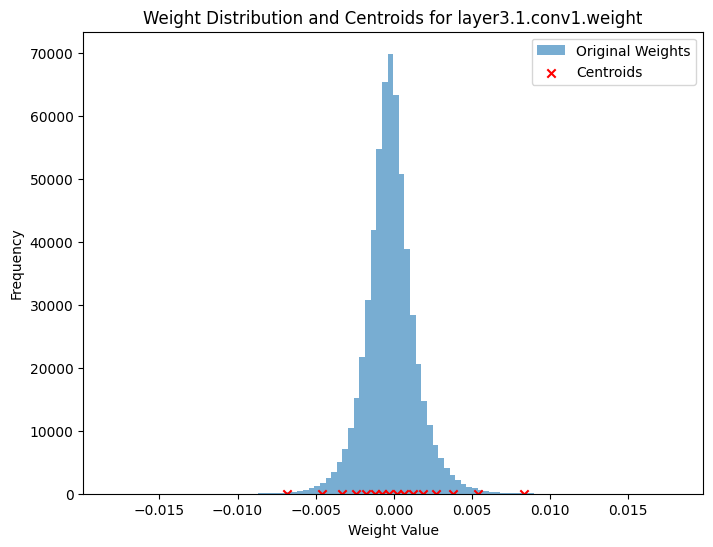

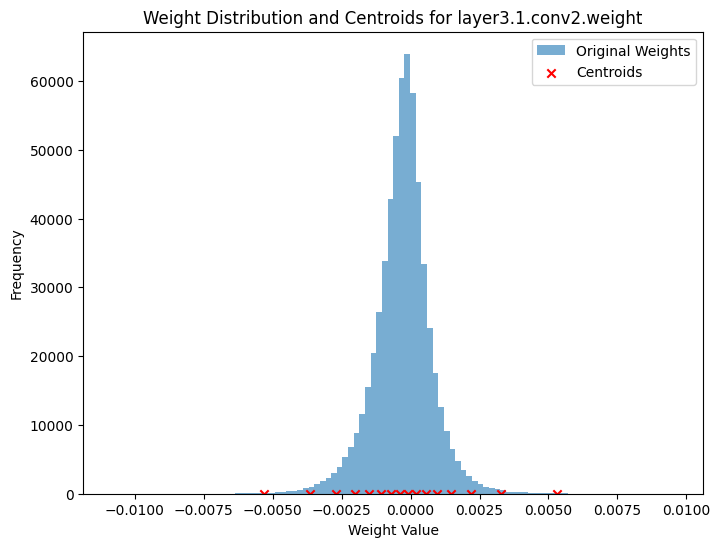

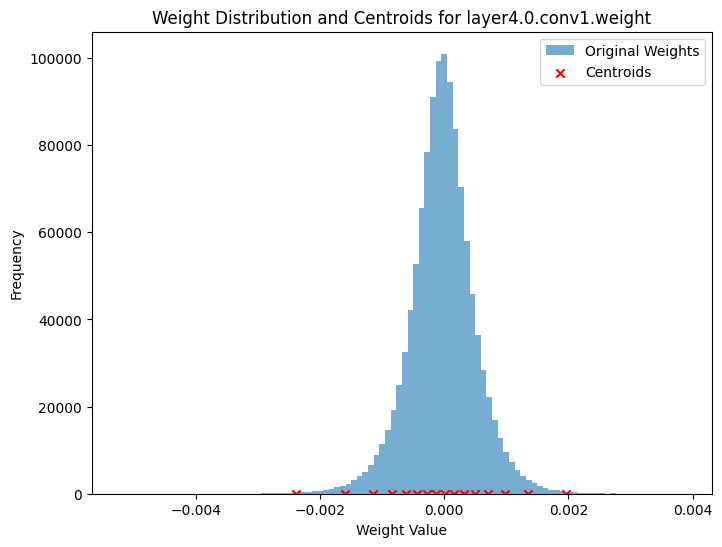

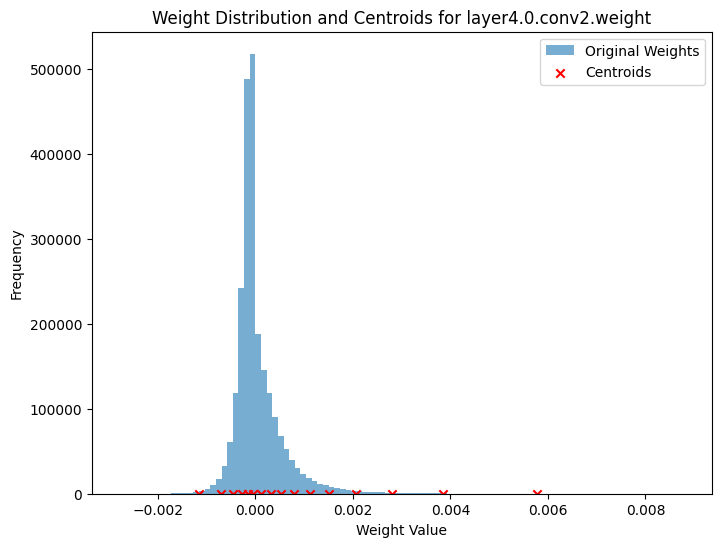

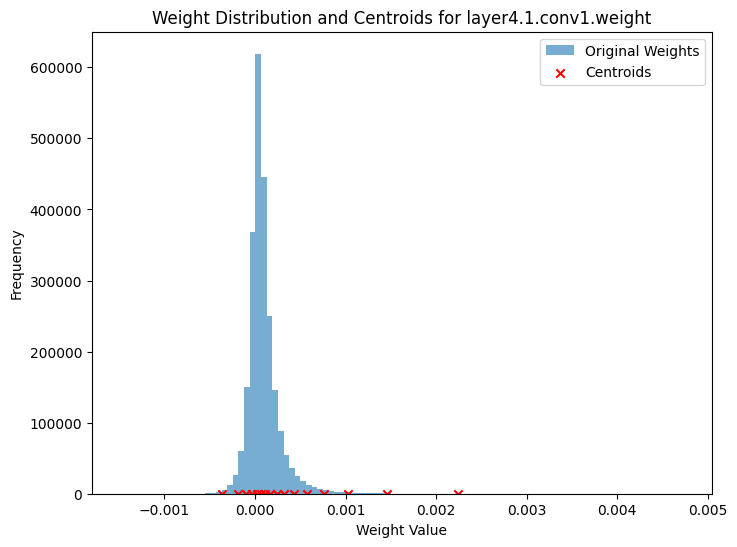

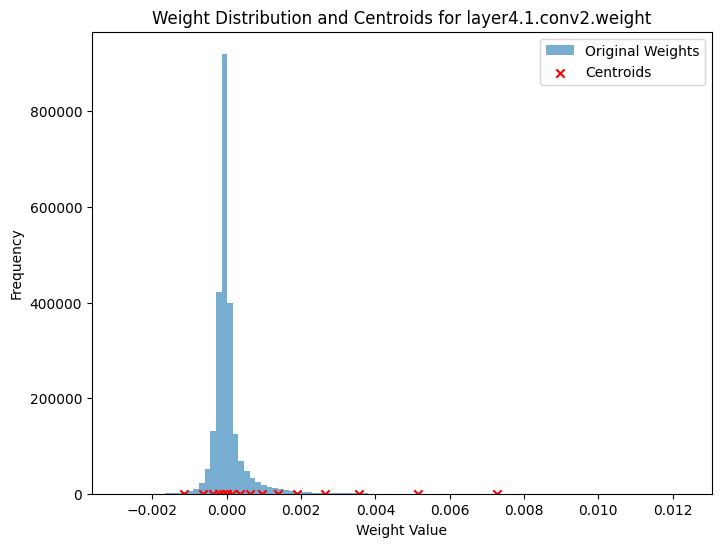

In [ ]:
def uniform_quantization(tensor, num_bits=NUM_BITS, name=None):
    min_val, max_val = tensor.min(), tensor.max()

    # Compute Fisher Information sensitivity mask
    if name and name in fisher_information:
        fisher_info = fisher_information[name]
        sensitivity_mask = fisher_info > torch.quantile(fisher_info, 0.45)
        sensitive_weights = tensor[sensitivity_mask]
    else:
        sensitivity_mask = torch.abs(tensor) > torch.quantile(torch.abs(tensor), 0.45)
        sensitive_weights = tensor[sensitivity_mask]

    offset = sensitive_weights.mean() if sensitive_weights.numel() > 0 else tensor.mean()
    tensor_shifted = tensor - offset

    # Apply sensitivity-aware clustering (k-means)
    tensor_flat = tensor.view(-1, 1).cpu().numpy()
    kmeans = KMeans(n_clusters=2 ** num_bits, n_init=10).fit(tensor_flat)
    clustered_tensor = torch.tensor(kmeans.cluster_centers_[kmeans.labels_], device=tensor.device).view(tensor.shape)

    # Apply sensitivity-aware clustering (k-means)
    #tensor_flat = sensitive_weights.view(-1, 1).cpu().numpy()
    #kmeans_sens = KMeans(n_clusters=2 ** num_bits, n_init=10).fit(tensor_flat)
    #clustered_tensor = torch.tensor(kmeans.cluster_centers_[kmeans.labels_], device=tensor.device).view(tensor.shape)
    fisher_flat = fisher_info.view(-1)  # Flatten
    top_indices = torch.argsort(fisher_flat, descending=True)[:20]  # Get top 20 indices
    top_sensitive_weights = tensor_flat[top_indices].tolist()  # Store top values

    # Plot centroids and weight distribution
    plt.figure(figsize=(8, 6))
    plt.hist(tensor.cpu().numpy().flatten(), bins=100, alpha=0.6, label="Original Weights")
    plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), color='red', label="Centroids", marker='x')
    #plt.scatter(top_sensitive_weights, np.zeros_like(top_sensitive_weights), color='green', label="Centroids", marker='x')
    plt.title(f"Weight Distribution and Centroids for {name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
# Apply Uniform Quantization to Conv Layers Only
for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        uniform_quantization(param.data, name=name)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
BETA = 2.0
LAMBDA = 0.01  # Regularization weight
A_BASE = 0.05  # Default power function base value
GAMMA = 0.5  # Controls adaptation strength

def compute_fisher_information(model, dataloader, device):
    model.eval()
    fisher_information = {}
    for name, param in model.named_parameters():
        if "weight" in name:
            fisher_information[name] = torch.zeros_like(param, device=device)

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if "weight" in name and param.grad is not None:
                fisher_information[name] += (param.grad ** 2)
        break

    return fisher_information

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

# Compute Fisher Information
fisher_information = compute_fisher_information(model, train_loader, device)

# Compute Sensitivity Weighted Matrix
def compute_sensitivity_weighted_matrix(tensor, fisher_info):
    sensitivity_weights = fisher_info / (torch.max(fisher_info) + 1e-8)  # Normalize sensitivity values
    weighted_matrix = tensor * sensitivity_weights  # Element-wise multiplication
    return weighted_matrix, sensitivity_weights

# Compute per-layer adaptive power function a
def compute_adaptive_a(fisher_info):
    normalized_fisher = fisher_info.mean() / (fisher_info.max() + 1e-8)  # Normalize to [0,1]
    return 0.55
    #return A_BASE + GAMMA * (1 - normalized_fisher)

# Modify uniform quantization to use sensitivity weighted matrix mean
def uniform_quantization(tensor, num_bits=NUM_BITS, name=None):
    min_val, max_val = tensor.min(), tensor.max()

    # Compute Fisher Information sensitivity mask
    if name and name in fisher_information:
        fisher_info = fisher_information[name]
        weighted_matrix ,sensitivity_weights = compute_sensitivity_weighted_matrix(tensor, fisher_info)
        #offset = (weighted_matrix.sum() / sensitivity_weights.sum()).item()
        offset = tensor.mean().item()
        # Adapt power function based on sensitivity
        adaptive_a = compute_adaptive_a(fisher_info)
    else:
        offset = tensor.mean().item()
        adaptive_a = torch.full_like(tensor, 0.55)

    print(offset)
    print(adaptive_a)
    # Default power value if no sensitivity info
    # Apply sensitivity-aware clustering (k-means)
    #tensor_flat = tensor_shifted.view(-1, 1).cpu().numpy()
    #kmeans = KMeans(n_clusters=2 ** num_bits, n_init=10).fit(tensor_flat)
    #clustered_tensor = torch.tensor(kmeans.cluster_centers_[kmeans.labels_], device=tensor.device).view(tensor.shape)
    tensor_shifted = tensor - offset

    # Apply power function scaling (x^0.55)
    tensor_sign = torch.sign(tensor_shifted)
    tensor_scaled = tensor_shifted.abs() ** adaptive_a * tensor_sign  # Preserve sign

    scale = (tensor_scaled.max() - tensor_scaled.min()) / (2 ** num_bits - 1)
    quantized_tensor = torch.round((tensor_scaled - tensor_scaled.min()) / scale) * scale + tensor_scaled.min()

    # Descale back to original range and apply offset correction
    quantized_tensor = ((quantized_tensor.abs() ** (1/adaptive_a)) * torch.sign(quantized_tensor)) + offset

    return quantized_tensor

# Apply Uniform Quantization to Conv Layers Only
for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        param.data = uniform_quantization(param.data, name=name)

# Reload state dict to ensure updated weights are used
#model.load_state_dict(model.state_dict())

# Evaluate Model after Quantization
def evaluate(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy after Quantization: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-23-152dedca30df>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


-0.0005907987360842526
0.55
-0.0005312355933710933
0.55
-0.00038865581154823303
0.55
-0.0004040412895847112
0.55
-0.0004977902863174677
0.55
-0.0006040212465450168
0.55
-0.0004886134411208332
0.55
-0.0005380698712542653
0.55
-0.0005172945093363523
0.55
-0.0002259942120872438
0.55
-0.00016324553871527314
0.55
-0.00020669298828579485
0.55
-0.0002927689638454467
0.55
-3.338038004585542e-05
0.55
4.645423905458301e-05
0.55
9.021561709232628e-05
0.55
2.5723662474774756e-05
0.55
Test Accuracy after Quantization: 83.07%


In [ ]:
# Reduce model size and dataset for memory efficiency
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Use a smaller dataset
subset_trainset = torch.utils.data.Subset(trainset, range(0, 5000))  # Reduce training set to 5000 images
subset_testset = torch.utils.data.Subset(testset, range(0, 1000))  # Reduce test set to 1000 images

trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(subset_testset, batch_size=64, shuffle=False, num_workers=2)

# Train and evaluate new small model
small_model = SmallCNN().to(device)
optimizer = optim.Adam(small_model.parameters(), lr=0.001)

print("Training smaller baseline model...")
train_model(small_model, trainloader, criterion, optimizer, epochs=3)
baseline_acc = evaluate_model(small_model, testloader)
print(f"Smaller Baseline Model Accuracy: {baseline_acc:.4f}")
# Function to perform hybrid Tucker decomposition with quantization
def quantize_tensor(tensor, bits=4):
    """Applies k-bit uniform quantization to a tensor."""
    qmin = -2**(bits-1)
    qmax = 2**(bits-1) - 1
    scale = (tensor.max() - tensor.min()) / (qmax - qmin)
    tensor_q = torch.round(tensor / scale).clamp(qmin, qmax)
    return tensor_q * scale

def get_adaptive_tucker_rank(tensor, energy_threshold=0.95):
    """Selects Tucker decomposition rank dynamically based on energy preservation."""
    ranks = []
    for mode in range(len(tensor.shape)):
        unfold = tl.unfold(tensor, mode)
        U, S, V = torch.svd(unfold)
        cumulative_energy = torch.cumsum(S, dim=0) / torch.sum(S)
        rank = torch.sum(cumulative_energy < energy_threshold).item() + 1
        ranks.append(rank)
    return tuple(ranks)

def hybrid_tucker_quantization(weight_tensor, quant_bits=4, energy_threshold=0.95):
    """Applies Tucker decomposition with adaptive rank selection and quantization."""
    rank = get_adaptive_tucker_rank(weight_tensor, energy_threshold)
    print(rank)
    #core, factors = tucker(weight_tensor, ranks=rank)
    #core_q = quantize_tensor(core, bits=quant_bits)
    #reconstructed = tl.tucker_to_tensor((core_q, factors))
    return weight_tensor
# Apply Tucker compression to a single layer (conv1 only) for testing
def compress_single_layer(model, layer_name):
    """Applies Tucker + Quantization only to a specific layer."""
    for name, param in model.named_parameters():
        if layer_name in name and 'weight' in name:
            print(f"Compressing {name}...")
            param.data = hybrid_tucker_quantization(param.data, quant_bits=4, energy_threshold=0.95)
    return model

compressed_model = compress_single_layer(small_model, "conv1")

# Fine-tune after compression
print("Fine-tuning compressed small model...")
train_model(compressed_model, trainloader, criterion, optimizer, epochs=3)

# Evaluate compressed model
compressed_acc = evaluate_model(compressed_model, testloader)
print(f"Compressed Model Accuracy: {compressed_acc:.4f}")

# Return accuracy results
baseline_acc, compressed_acc


Training smaller baseline model...
Epoch 1, Loss: 1.9802278144450127
Epoch 2, Loss: 1.646470074412189
Epoch 3, Loss: 1.507406676871867
Smaller Baseline Model Accuracy: 0.4720
Compressing conv1.weight...
(14, 3, 3, 3)
Fine-tuning compressed small model...
Epoch 1, Loss: 1.4321407864365396
Epoch 2, Loss: 1.3375384324713597
Epoch 3, Loss: 1.2604732241811631
Compressed Model Accuracy: 0.4680


(0.472, 0.468)

In [ ]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import tensorly as tl
from tensorly.decomposition import tucker
import numpy as np

tl.set_backend('pytorch')  # Use PyTorch as backend for TensorLy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CNN model for CIFAR-10
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Train function
def train_model(model, trainloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

# Evaluate function
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Initialize and train model
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training baseline model...")
train_model(model, trainloader, criterion, optimizer, epochs=5)

# Baseline Accuracy
baseline_acc = evaluate_model(model, testloader)
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# Function to perform hybrid Tucker decomposition with quantization
def quantize_tensor(tensor, bits=4):
    """Applies k-bit uniform quantization to a tensor."""
    qmin = -2**(bits-1)
    qmax = 2**(bits-1) - 1
    scale = (tensor.max() - tensor.min()) / (qmax - qmin)
    tensor_q = torch.round(tensor / scale).clamp(qmin, qmax)
    return tensor_q * scale

def get_adaptive_tucker_rank(tensor, energy_threshold=0.95):
    """Selects Tucker decomposition rank dynamically based on energy preservation."""
    ranks = []
    for mode in range(len(tensor.shape)):
        unfold = tl.unfold(tensor, mode)
        U, S, V = torch.svd(unfold)
        cumulative_energy = torch.cumsum(S, dim=0) / torch.sum(S)
        rank = torch.sum(cumulative_energy < energy_threshold).item() + 1
        ranks.append(rank)
    return tuple(ranks)

def hybrid_tucker_quantization(weight_tensor, quant_bits=4, energy_threshold=0.95):
    """Applies Tucker decomposition with adaptive rank selection and quantization."""
    rank = get_adaptive_tucker_rank(weight_tensor, energy_threshold)
    core, factors = tucker(weight_tensor, ranks=rank)
    core_q = quantize_tensor(core, bits=quant_bits)
    reconstructed = tl.tucker_to_tensor((core_q, factors))
    return reconstructed

# Apply compression to convolutional layers
def compress_model(model):
    for name, param in model.named_parameters():
        if 'conv' in name and 'weight' in name:
            print(f"Compressing {name}...")
            param.data = hybrid_tucker_quantization(param.data, quant_bits=4, energy_threshold=0.95)
    return model

# Compress and fine-tune the model
compressed_model = compress_model(model)
print("Fine-tuning compressed model...")
train_model(compressed_model, trainloader, criterion, optimizer, epochs=3)

# Evaluate compressed model accuracy
compressed_acc = evaluate_model(compressed_model, testloader)
print(f"Compressed Model Accuracy: {compressed_acc:.4f}")

# Return accuracy results
baseline_acc, compressed_acc


Files already downloaded and verified
Files already downloaded and verified
Training baseline model...
Epoch 1, Loss: 1.344856800020808
Epoch 2, Loss: 0.9728826912467742
Epoch 3, Loss: 0.8091560569413178


KeyboardInterrupt: 

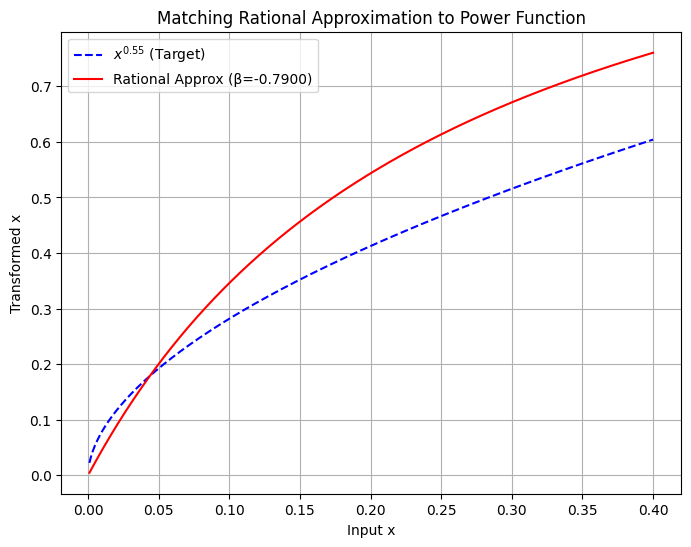

-0.79

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the original power function
def power_function(x, alpha=0.55):
    return np.sign(x) * np.abs(x) ** alpha

# Define the rational approximation function
def rational_approximation(x, beta):
    return x / (1 + beta * (1 - x))

# Generate a range of input values
x_values = np.linspace(0.001, 0.4, 1000)  # Avoid zero to prevent division issues

# Compute outputs for different beta values
alpha_target = 0.55
best_beta = None
min_error = float('inf')

beta_values = np.linspace(-1, 0, 1000)  # Search range for beta

for beta in beta_values:
    rational_output = rational_approximation(x_values, beta)
    power_output = power_function(x_values, alpha_target)

    # Compute mean squared error between rational and power approximation
    error = np.mean((rational_output - power_output) ** 2)

    if error < min_error:
        min_error = error
        best_beta = beta
best_beta = -0.79
# Plot the best match
plt.figure(figsize=(8, 6))
plt.plot(x_values, power_function(x_values, alpha_target), label=r'$x^{0.55}$ (Target)', linestyle='dashed', color='blue')
plt.plot(x_values, rational_approximation(x_values, best_beta), label=f'Rational Approx (β={best_beta:.4f})', color='red')
plt.xlabel("Input x")
plt.ylabel("Transformed x")
plt.legend()
plt.title("Matching Rational Approximation to Power Function")
plt.grid()
plt.show()

best_beta


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import numpy as np

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
BETA = 2.0
LAMBDA = 0.01  # Regularization weight

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

# Rational Approximation-Based Uniform Quantization
def rational_approximation_quantization(tensor, num_bits=NUM_BITS, beta=-0.79):
    min_val, max_val = tensor.min(), tensor.max()

    # Compute offset to center weights
    offset = tensor.mean()
    tensor_shifted = tensor - offset

    # Apply rational approximation scaling
    tensor_scaled = tensor_shifted / (1 + beta * (1 - tensor_shifted))

    scale = (tensor_scaled.max() - tensor_scaled.min()) / (2 ** num_bits - 1)
    quantized_tensor = torch.round((tensor_scaled - tensor_scaled.min()) / scale) * scale + tensor_scaled.min()

    # Descale back to original range and apply offset correction
    quantized_tensor = (quantized_tensor * (1 + beta * (1 - quantized_tensor))) + offset

    return quantized_tensor

# Apply Uniform Quantization to Conv Layers Only
for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        param.data = rational_approximation_quantization(param.data)

# Evaluate Model after Quantization
def evaluate(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy after Quantization: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-27-c906fb4fc969>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


Test Accuracy after Quantization: 9.96%


100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


<ipython-input-1-23761faa42cd>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


Applying DAQ Quantization to conv1.weight...
Applying DAQ Quantization to layer1.0.conv1.weight...
Applying DAQ Quantization to layer1.0.conv2.weight...
Applying DAQ Quantization to layer1.1.conv1.weight...
Applying DAQ Quantization to layer1.1.conv2.weight...
Applying DAQ Quantization to layer2.0.conv1.weight...
Applying DAQ Quantization to layer2.0.conv2.weight...
Applying DAQ Quantization to layer2.1.conv1.weight...
Applying DAQ Quantization to layer2.1.conv2.weight...
Applying DAQ Quantization to layer3.0.conv1.weight...
Applying DAQ Quantization to layer3.0.conv2.weight...
Applying DAQ Quantization to layer3.1.conv1.weight...
Applying DAQ Quantization to layer3.1.conv2.weight...
Applying DAQ Quantization to layer4.0.conv1.weight...
Applying DAQ Quantization to layer4.0.conv2.weight...
Applying DAQ Quantization to layer4.1.conv1.weight...
Applying DAQ Quantization to layer4.1.conv2.weight...
Epoch 1/10, Loss: 0.000198
Epoch 2/10, Loss: 0.000192
Epoch 3/10, Loss: 0.000185
Epoch 4/10

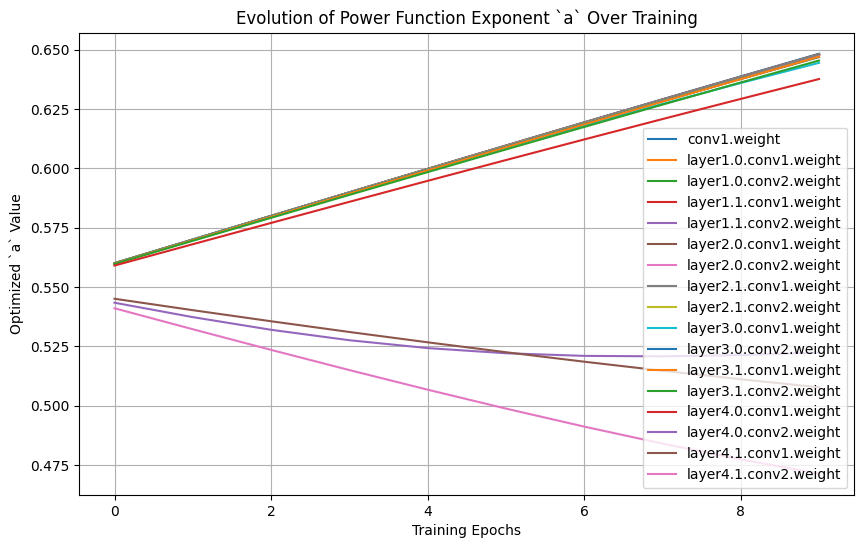

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import matplotlib.pyplot as plt

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
INIT_A = 0.55  # Initial power function exponent
FIXED_T = 5.0  # Fixed temperature for soft rounding
LR = 0.01  # Learning rate
EPOCHS = 10  # Training epochs for optimizing `a`

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)


# ====== Define Differentiable Quantization Model for Finding Optimal `a` ======
class DAQPowerQuantization(nn.Module):
    def __init__(self, num_levels=2**NUM_BITS, init_a=INIT_A, fixed_T=FIXED_T):
        """
        Differentiable quantization with trainable power function exponent using Distance-Aware Soft Rounding.

        Args:
        - num_levels (int): Number of quantization levels.
        - init_a (float): Initial power function exponent.
        - fixed_T (float): Fixed temperature for soft rounding.
        """
        super().__init__()
        self.num_levels = num_levels
        self.a = nn.Parameter(torch.tensor(init_a, dtype=torch.float32))  # Trainable power exponent
        self.fixed_T = fixed_T  # Fixed temperature for soft rounding

    def forward(self, w):
        # Apply trainable power function scaling
        offset = w.mean()  # Centering the weights
        w_shifted = w - offset
        w_transformed = torch.sign(w_shifted) * (torch.abs(w_shifted) ** self.a)

        # Normalize weights to [0, 1]
        w_min, w_max = w_transformed.min(), w_transformed.max()
        w_normalized = (w_transformed - w_min) / (w_max - w_min + 1e-6)  # Avoid division by zero

        # Define quantization levels
        q_levels = torch.linspace(0, 1, self.num_levels, device=w.device)

        # Compute soft assignment weights (distance-aware rounding)
        distances = -torch.abs(w_normalized.unsqueeze(-1) - q_levels)  # Negative for softmax
        soft_weights = torch.softmax(distances * self.fixed_T, dim=-1)  # Fixed temperature

        # Compute soft quantized value as a weighted sum
        w_quantized = (soft_weights * q_levels).sum(dim=-1)

        # De-normalize back to original scale
        w_dequantized = w_quantized * (w_max - w_min) + w_min
        w_dequantized = (torch.abs(w_dequantized) ** (1/self.a)) * torch.sign(w_dequantized) + offset  # Descale

        return w_dequantized


# ====== Apply DAQ-Based Quantization to Convolution Layers ======
quantization_layers = {}

for name, param in model.named_parameters():
    if "conv" in name and "weight" in name:
        print(f"Applying DAQ Quantization to {name}...")
        quantization_layers[name] = DAQPowerQuantization().to(device)

# Define optimizer for all trainable power exponents `a`
optimizer = optim.Adam([param for layer in quantization_layers.values() for param in layer.parameters()], lr=LR)
loss_fn = nn.MSELoss()

# Track per-layer `a` values for visualization
a_tracking = {name: [] for name in quantization_layers.keys()}

# ====== Training Loop to Optimize `a` for Each Layer ======
for epoch in range(EPOCHS):
    total_loss = 0
    for name, param in model.named_parameters():
        if name in quantization_layers:
            quant_layer = quantization_layers[name]

            optimizer.zero_grad()
            quantized_weights = quant_layer(param)  # Apply differentiable quantization
            loss = loss_fn(quantized_weights, param)  # Minimize reconstruction error

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            a_tracking[name].append(quant_layer.a.item())  # Track changes in `a`

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss:.6f}")

# Update model parameters with learned `a`
for name, param in model.named_parameters():
    if name in quantization_layers:
        param.data = quantization_layers[name](param).detach()


# ====== Evaluate Model After Quantization ======
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy after Quantization: {100 * correct / total:.2f}%")


# Run Evaluation
evaluate(model, test_loader)

# Print Learned `a` Values
for name, layer in quantization_layers.items():
    print(f"Optimized `a` for {name}: {layer.a.item():.4f}")

# ====== Plot how `a` evolves over training ======
plt.figure(figsize=(10, 6))
for name, values in a_tracking.items():
    plt.plot(range(EPOCHS), values, label=name)

plt.xlabel("Training Epochs")
plt.ylabel("Optimized `a` Value")
plt.title("Evolution of Power Function Exponent `a` Over Training")
plt.legend()
plt.grid()
plt.show()


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import matplotlib.pyplot as plt

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
INIT_A = 0.55  # Initial power function exponent
FIXED_T = 100  # Fixed temperature for soft rounding
LR = 0  # Learning rate
EPOCHS = 10  # Training epochs for optimizing `a`
NUM_ITERATIONS = 100  # Per-layer optimization iterations

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)
print("Accuracy BEFORE Quantization:")
evaluate(model, test_loader)

# ====== Define Differentiable Per-Layer Quantization Model ======
class DAQPowerQuantization(nn.Module):
    def __init__(self, num_levels=2**NUM_BITS, init_a=INIT_A, fixed_T=FIXED_T):
        """
        Differentiable quantization with trainable power function exponent using Distance-Aware Soft Rounding.

        Args:
        - num_levels (int): Number of quantization levels.
        - init_a (float): Initial power function exponent.
        - fixed_T (float): Fixed temperature for soft rounding.
        """
        super().__init__()
        self.num_levels = num_levels
        self.a = nn.Parameter(torch.tensor(init_a, dtype=torch.float32))  # Trainable power exponent
        self.fixed_T = fixed_T  # Fixed temperature for soft rounding

    def forward(self, w):
        # Apply trainable power function scaling
        offset = w.mean()  # Centering the weights
        w_shifted = w - offset
        EPSILON = 1e-6
        w_transformed = torch.sign(w_shifted) * (torch.abs(w_shifted) ** self.a) + EPSILON

        # Normalize weights to [0, 1]
        w_min, w_max = w_transformed.min(), w_transformed.max()
        w_normalized = (w_transformed - w_min) / (w_max - w_min + 1e-6)  # Avoid division by zero

        # Define quantization levels
        q_levels = torch.linspace(0, 1, self.num_levels, device=w.device)

        # Compute soft assignment weights (distance-aware rounding)
        distances = -torch.abs(w_normalized.unsqueeze(-1) - q_levels)  # Negative for softmax
        soft_weights = torch.softmax(distances * self.fixed_T, dim=-1)  # Fixed temperature

        # Compute soft quantized value as a weighted sum
        w_quantized = (soft_weights * q_levels).sum(dim=-1)

        # De-normalize back to original scale
        w_dequantized = w_quantized * (w_max - w_min) + w_min
        w_dequantized = (torch.abs(w_dequantized) ** (1/self.a)) * torch.sign(w_dequantized) + offset  # Descale

        return w_dequantized



# Define Cross-Entropy Loss for Classification
classification_loss_fn = nn.CrossEntropyLoss()
# ====== Store Layer Activations for Per-Layer Optimization ======
temp_activations = {}

def activation_hook(layer_name):
    def hook(module, input, output):
        temp_activations[layer_name] = input[0].detach()
    return hook

# Register hooks for convolutional layers
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(activation_hook(name))

# ====== Per-Layer Optimization Function ======
def optimize_per_layer(model, test_loader, num_iterations=NUM_ITERATIONS, lr=LR):
    model.to(device)
    model.eval()
    updated_state_dict = model.state_dict()
    quantization_layers = {}

    print("Starting per-layer quantization optimization...")

    for name, param in model.named_parameters():
        if "conv" in name and "weight" in name:
            print(f"Optimizing {name}...")
            layer_name = name.replace(".weight", "")

            if layer_name not in temp_activations:
                continue  # Skip if activation was not stored

            # Initialize differentiable quantization module for this layer
            quantization_layers[layer_name] = DAQPowerQuantization().to(device)
            quant_layer = quantization_layers[layer_name]

            optimizer = optim.Adam(quant_layer.parameters(), lr=lr)
            loss_fn = nn.MSELoss()

            # Retrieve stored activations
            x = temp_activations[layer_name]
            original_weight = param.clone().detach()

            # Track `a` values
            a_tracking = []
            prev_loss = 100
            # Per-layer optimization loop
            for iter in range(num_iterations):
                optimizer.zero_grad()
                quantized_weight = quant_layer(original_weight)  # Apply DAQ quantization

                # Compute output difference
                quantized_output = nn.functional.conv2d(x, quantized_weight, stride=param.shape[2], padding=param.shape[3])
                original_output = nn.functional.conv2d(x, original_weight, stride=param.shape[2], padding=param.shape[3])

                # Loss = Difference in activation outputs
                #loss = loss_fn(quantized_output, original_output)
                reconstruction_loss = loss_fn(quantized_output, original_output)
                if reconstruction_loss < 0.00000020:
                  break

                if prev_loss<reconstruction_loss:
                    break
                prev_loss = reconstruction_loss

                # Get a batch of test images and labels
                images, labels = next(iter(test_loader))
                images, labels = images.to(device), labels.to(device)

                # Temporarily replace model weight with quantized weight
                with torch.no_grad():
                    param.copy_(quantized_weight)

                # Compute classification loss with quantized model
                classification_loss = classification_loss_fn(model(images), labels)

                # Restore original weight after loss computation
                with torch.no_grad():
                    param.copy_(original_weight)

                # Compute total loss
                final_loss = 0.9 * reconstruction_loss + 0.1 * classification_loss

                final_loss.backward()





                loss.backward()
                optimizer.step()

                a_tracking.append(quant_layer.a.item())

                if iter % 10 == 0:
                    print(f"Iter {iter}: Loss = {loss.item():.8f}, a = {quant_layer.a.item():.4f}")

            # Update model weight with learned quantized version
            updated_state_dict[name] = quant_layer(original_weight).detach()

            # Plot `a` evolution for this layer
            #plt.plot(range(num_iterations), a_tracking, label=layer_name)

    model.load_state_dict(updated_state_dict)
    print("Per-layer optimization complete.")

# Run forward pass to store activations
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        model(images)
        break  # Single batch needed

# Apply optimized quantization per layer
optimize_per_layer(model, test_loader)

# ====== Evaluate Model After Quantization ======
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy after Quantization: {100 * correct / total:.2f}%")

# Run evaluation
evaluate(model, test_loader)

# ====== Plot how `a` evolves per layer ======
plt.xlabel("Iterations")
plt.ylabel("Optimized `a` Value")
plt.title("Evolution of Power Function Exponent `a` Per Layer")
plt.legend()
plt.grid()
plt.show()


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-15-6b231326a2ab>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


Accuracy BEFORE Quantization:
Test Accuracy: 86.53%
Starting per-layer quantization optimization...
Optimizing conv1.weight...


TypeError: 'int' object is not callable

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import timm
import matplotlib.pyplot as plt

# Hyperparameters
BATCH_SIZE = 128
NUM_BITS = 3
INIT_A = 0.55  # Initial power function exponent
FIXED_T = 100.5  # Fixed temperature for soft rounding
LR = 0.001  # Corrected Learning rate
EPOCHS = 10  # Training epochs for optimizing `a`
NUM_ITERATIONS = 100  # Per-layer optimization iterations

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet18 from timm
import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18.resnet18(pretrained=False, device=device)
model.to(device)

state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to(device)

print("Accuracy BEFORE Quantization:")
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

#evaluate(model, test_loader)

# ====== Define Differentiable Per-Layer Quantization Model ======
class DAQPowerQuantization(nn.Module):
    def __init__(self, num_levels=2**NUM_BITS, init_a=INIT_A, fixed_T=FIXED_T):
        super().__init__()
        self.num_levels = num_levels
        self.a = nn.Parameter(torch.tensor(init_a, dtype=torch.float32))  # Trainable power exponent
        self.fixed_T = fixed_T  # Fixed temperature for soft rounding

    def forward(self, w):
        # Apply trainable power function scaling
        offset = w.mean()  # Centering the weights
        w_shifted = w - offset
        EPSILON = 1e-6
        w_transformed = torch.sign(w_shifted) * (torch.abs(w_shifted) ** self.a) + EPSILON

        # Normalize weights to [0, 1]
        w_min, w_max = w_transformed.min(), w_transformed.max()
        w_normalized = (w_transformed - w_min) / (w_max - w_min + 1e-6)  # Avoid division by zero

        # Define quantization levels
        q_levels = torch.linspace(0, 1, self.num_levels, device=w.device)

        # Compute soft assignment weights (distance-aware rounding)
        distances = -torch.abs(w_normalized.unsqueeze(-1) - q_levels)  # Negative for softmax
        soft_weights = torch.softmax(distances * self.fixed_T, dim=-1)  # Fixed temperature

        # Compute soft quantized value as a weighted sum
        w_quantized = (soft_weights * q_levels).sum(dim=-1)

        # De-normalize back to original scale
        w_dequantized = w_quantized * (w_max - w_min) + w_min
        w_dequantized = (torch.abs(w_dequantized) ** (1/self.a)) * torch.sign(w_dequantized) + offset  # Descale

        return w_dequantized


# Define Cross-Entropy Loss for Classification
classification_loss_fn = nn.CrossEntropyLoss()

# ====== Store Layer Activations for Per-Layer Optimization ======
temp_activations = {}

def activation_hook(layer_name):
    def hook(module, input, output):
        temp_activations[layer_name] = input[0].detach()
    return hook

# Register hooks for convolutional layers
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(activation_hook(name))

# ====== Per-Layer Optimization Function ======
def optimize_per_layer(model, test_loader, num_iterations=NUM_ITERATIONS, lr=LR):
    model.to(device)
    model.eval()
    updated_state_dict = model.state_dict()
    quantization_layers = {}
    print("Starting per-layer quantization optimization...")

    # Ensure `iter` is not overwritten
    from builtins import iter
    # Get a batch of test images and labels before optimization
    data_iterator = iter(test_loader)
    images, labels = next(data_iterator)
    images, labels = images.to(device), labels.to(device)

    # Compute classification loss before optimization
    with torch.no_grad():
        outputs = model(images)
        pre_optimization_loss = classification_loss_fn(outputs, labels).item()

    print(f"Initial Classification Loss Before Optimization: {pre_optimization_loss:.6f}")

    print("Starting per-layer quantization optimization...")

    for name, param in model.named_parameters():
        if "conv" in name and "weight" in name:
            print(f"Optimizing {name}...")
            layer_name = name.replace(".weight", "")

            if layer_name not in temp_activations:
                continue  # Skip if activation was not stored

            # Initialize differentiable quantization module for this layer
            quantization_layers[layer_name] = DAQPowerQuantization().to(device)
            quant_layer = quantization_layers[layer_name]

            optimizer = optim.Adam(quant_layer.parameters(), lr=lr)
            loss_fn = nn.MSELoss()

            # Retrieve stored activations
            x = temp_activations[layer_name]
            original_weight = param.clone().detach()

            # Track `a` values
            a_tracking = []

            # Per-layer optimization loop
            prev_class_loss = 100
            for iter in range(num_iterations):
                optimizer.zero_grad()
                quantized_weight = quant_layer(original_weight)  # Apply DAQ quantization

                # Compute output difference
                quantized_output = nn.functional.conv2d(x, quantized_weight, stride=param.shape[2], padding=param.shape[3])
                original_output = nn.functional.conv2d(x, original_weight, stride=param.shape[2], padding=param.shape[3])

                # Reconstruction loss
                reconstruction_loss = loss_fn(quantized_output, original_output)

                if reconstruction_loss < 2e-7:
                    break

                # # Get a batch of test images and labels
                # for images, labels in test_loader:
                #     images, labels = images.to(device), labels.to(device)
                #     break  # Use only one batch

                # Temporarily replace model weight with quantized weight (without modifying in-place)
                with torch.no_grad():
                    temp_weight = quantized_weight.detach().clone()  # Clone to avoid in-place modification
                    param_backup = param.data.clone()  # Backup original weight
                    param.data.copy_(temp_weight)  # Replace with quantized weight

                # Compute classification loss with quantized model
                classification_loss = classification_loss_fn(model(images), labels)

                if prev_class_loss < classification_loss:
                    break
                prev_class_loss = classification_loss

                # Restore original weight after loss computation
                with torch.no_grad():
                    param.data.copy_(param_backup)

                # Compute total loss
                final_loss = 0.1 * reconstruction_loss + 0.9 * classification_loss
                final_loss.backward()
                optimizer.step()

                a_tracking.append(quant_layer.a.item())

                if iter % 10 == 0:
                    print(f"Iter {iter}: reconstruction_loss = {reconstruction_loss.item():.8f}, classification_loss = {classification_loss.item():.4f}, a = {quant_layer.a.item():.4f}")
                    #print(f"Iter {iter}: Loss = {final_loss.item():.8f}, a = {quant_layer.a.item():.4f}")

            updated_state_dict[name] = quant_layer(original_weight).detach()

    model.load_state_dict(updated_state_dict)
    print("Per-layer optimization complete.")

# Run forward pass to store activations
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        model(images)
        break  # Single batch needed

# Apply optimized quantization per layer
optimize_per_layer(model, test_loader)

# Evaluate Model After Quantization
evaluate(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-20-c82d6a8ecfef>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/resnet18.pt', map_location=torch.device('cpu'))


Accuracy BEFORE Quantization:
Starting per-layer quantization optimization...
Initial Classification Loss Before Optimization: 0.352729
Starting per-layer quantization optimization...
Optimizing conv1.weight...
Iter 0: reconstruction_loss = 0.00049095, classification_loss = 0.5178, a = 0.5490
Optimizing layer1.0.conv1.weight...
Iter 0: reconstruction_loss = 0.00000450, classification_loss = 0.5395, a = 0.5510
Optimizing layer1.0.conv2.weight...
Iter 0: reconstruction_loss = 0.00000120, classification_loss = 0.5905, a = 0.5490
Optimizing layer1.1.conv1.weight...
Iter 0: reconstruction_loss = 0.00000395, classification_loss = 0.5167, a = 0.5510
Optimizing layer1.1.conv2.weight...
Iter 0: reconstruction_loss = 0.00000033, classification_loss = 0.5189, a = 0.5494
Iter 10: reconstruction_loss = 0.00000033, classification_loss = 0.5186, a = 0.5444
Iter 20: reconstruction_loss = 0.00000033, classification_loss = 0.5185, a = 0.5414
Iter 30: reconstruction_loss = 0.00000033, classification_loss

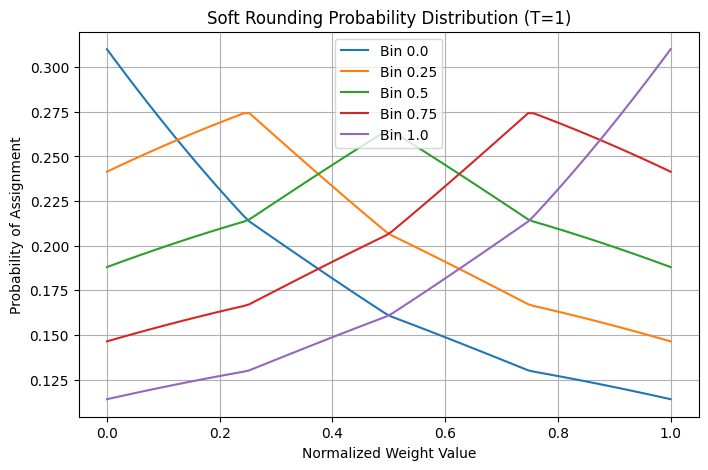

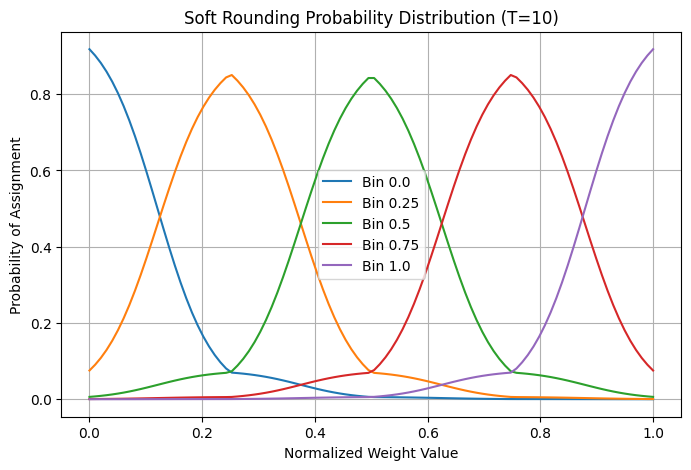

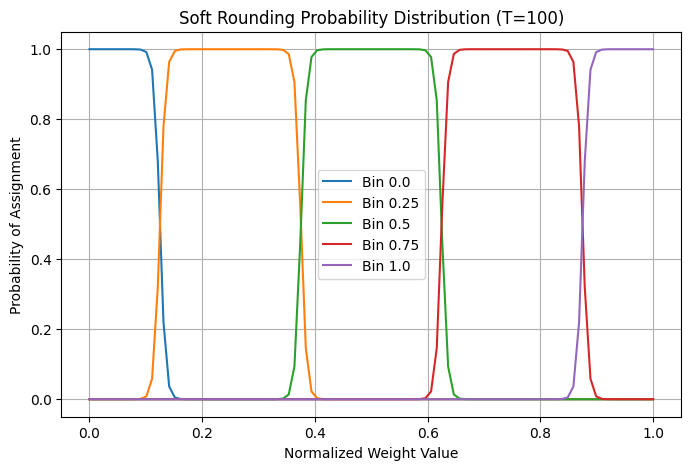

In [21]:
import torch
import matplotlib.pyplot as plt

T_values = [1, 10, 100]  # Compare soft vs. hard rounding cases
x = torch.linspace(0, 1, 100)  # Simulated normalized weight values
q_levels = torch.tensor([0, 0.25, 0.5, 0.75, 1])  # Example quantization levels

for T in T_values:
    distances = -torch.abs(x.unsqueeze(-1) - q_levels)
    soft_weights = torch.softmax(distances * T, dim=-1)

    plt.figure(figsize=(8, 5))
    for i in range(len(q_levels)):
        plt.plot(x.numpy(), soft_weights[:, i].numpy(), label=f"Bin {q_levels[i].item()}")

    plt.title(f"Soft Rounding Probability Distribution (T={T})")
    plt.xlabel("Normalized Weight Value")
    plt.ylabel("Probability of Assignment")
    plt.legend()
    plt.grid()
    plt.show()


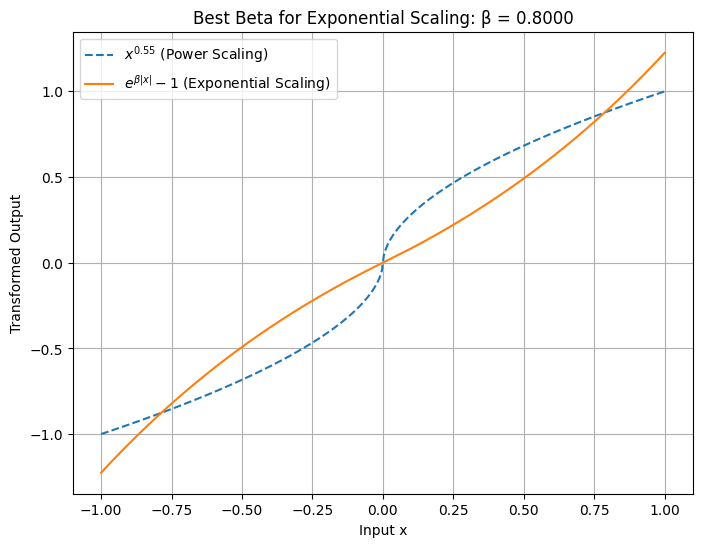

0.8

In [8]:
# Re-attempt optimized computation to find best beta for exponential scaling

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define power scaling (reference function)
def power_scaling(x, a=0.55):
    return np.sign(x) * (np.abs(x) ** a)

# Define exponential scaling function
def exp_scaling(x, beta):
    return np.sign(x) * (np.exp(beta * np.abs(x)) - 1)

# Generate a reduced test input in the range [-1, 1] for efficiency
x_vals = np.linspace(-1, 1, 300)  # Reduced sample size

# Target transformation using x^0.55
y_target = power_scaling(x_vals, a=0.55)

# Define loss function to find best beta
def loss_function(beta):
    y_exp = exp_scaling(x_vals, beta)
    return np.mean((y_target - y_exp) ** 2)  # Mean squared error

# Optimize beta using scipy's minimize function
result = minimize(loss_function, x0=np.array([1.0]), method="Nelder-Mead")

# Best beta value found
best_beta = result.x[0]
best_beta = .8

# Compute final transformed values using best beta
y_exp_optimal = exp_scaling(x_vals, best_beta)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_target, label=r"$x^{0.55}$ (Power Scaling)", linestyle="dashed")
plt.plot(x_vals, y_exp_optimal, label=r"$e^{\beta |x|} - 1$ (Exponential Scaling)", linestyle="solid")
plt.xlabel("Input x")
plt.ylabel("Transformed Output")
plt.legend()
plt.title(f"Best Beta for Exponential Scaling: β = {best_beta:.4f}")
plt.grid()
plt.show()

# Return the best beta value
best_beta


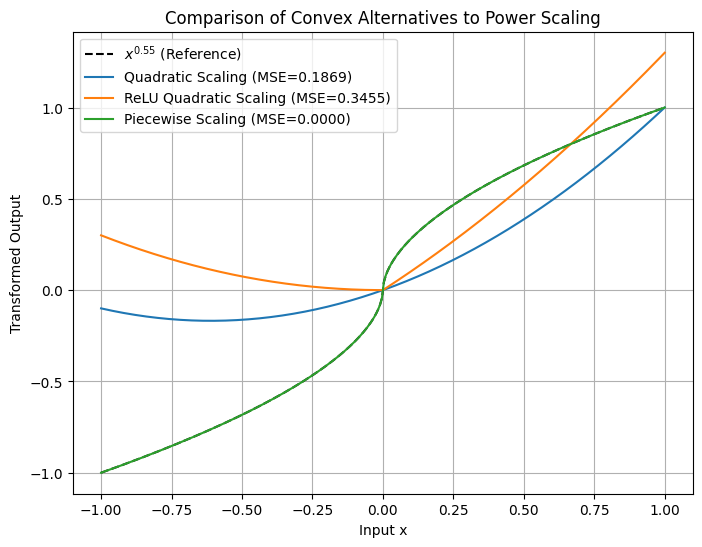

('Piecewise', 0.0)

In [10]:
# Define quadratic scaling function
def quadratic_scaling(x, alpha=0.45, beta=0.55):
    return alpha * x**2 + beta * x

# Define ReLU-like quadratic scaling function
def relu_quadratic_scaling(x, gamma=0.3):
    return np.maximum(0, x) + gamma * x**2

# Define piecewise power function
def piecewise_scaling(x, tau=0.0005, alpha=0.5, beta=0.55):
    return np.where(np.abs(x) < tau, alpha * x**2, np.sign(x) * (np.abs(x) ** beta))

# Generate test input in the range [-1, 1]
x_vals = np.linspace(-1, 1, 300)

# Compute transformations
y_target = power_scaling(x_vals, a=0.55)  # Reference: x^0.55
y_quadratic = quadratic_scaling(x_vals)
y_relu_quad = relu_quadratic_scaling(x_vals)
y_piecewise = piecewise_scaling(x_vals)

# Compute mean squared errors (MSE) with respect to x^0.55
mse_quadratic = np.mean((y_target - y_quadratic) ** 2)
mse_relu_quad = np.mean((y_target - y_relu_quad) ** 2)
mse_piecewise = np.mean((y_target - y_piecewise) ** 2)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_target, label=r"$x^{0.55}$ (Reference)", linestyle="dashed", color='black')
plt.plot(x_vals, y_quadratic, label=f"Quadratic Scaling (MSE={mse_quadratic:.4f})")
plt.plot(x_vals, y_relu_quad, label=f"ReLU Quadratic Scaling (MSE={mse_relu_quad:.4f})")
plt.plot(x_vals, y_piecewise, label=f"Piecewise Scaling (MSE={mse_piecewise:.4f})")

plt.xlabel("Input x")
plt.ylabel("Transformed Output")
plt.legend()
plt.title("Comparison of Convex Alternatives to Power Scaling")
plt.grid()
plt.show()

# Return the best alternative (lowest MSE)
best_alternative = min(
    [("Quadratic", mse_quadratic), ("ReLU Quadratic", mse_relu_quad), ("Piecewise", mse_piecewise)],
    key=lambda x: x[1]
)
best_alternative


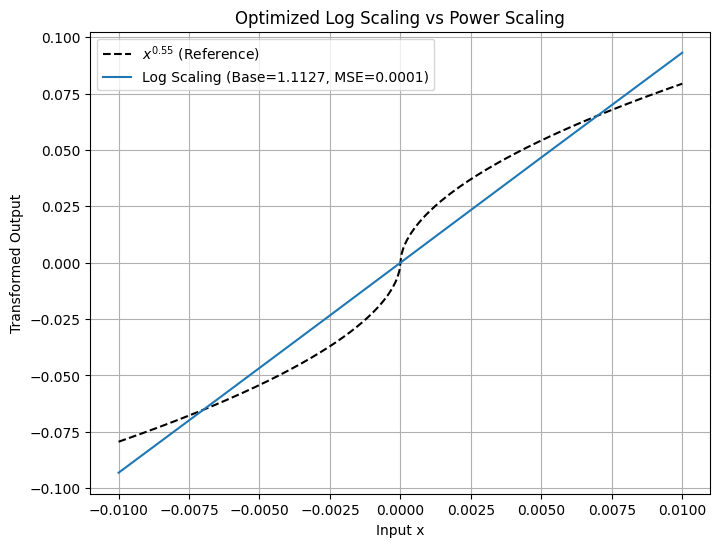

1.1126953124999992

In [15]:
# Define logarithmic scaling function with a variable base
def log_scaling(x, base=2):
    return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)

# Generate test input in the range [-1, 1]
x_vals = np.linspace(-0.01, 0.01, 300)

# Compute transformations
y_target = power_scaling(x_vals, a=0.55)  # Reference: x^0.55

# Optimize base to best match power scaling
def loss_function(base):
    y_log = log_scaling(x_vals, base)
    return np.mean((y_target - y_log) ** 2)  # Mean squared error

# Use scipy's minimize function to find the best base
from scipy.optimize import minimize
result = minimize(loss_function, x0=np.array([2.0]), method="Nelder-Mead")

# Best base value found
best_base = result.x[0]

# Compute final transformed values using best base
y_log_optimal = log_scaling(x_vals, best_base)

# Compute MSE for optimized log function
mse_log_optimal = np.mean((y_target - y_log_optimal) ** 2)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(x_vals, y_target, label=r"$x^{0.55}$ (Reference)", linestyle="dashed", color='black')
plt.plot(x_vals, y_log_optimal, label=f"Log Scaling (Base={best_base:.4f}, MSE={mse_log_optimal:.4f})")

plt.xlabel("Input x")
plt.ylabel("Transformed Output")
plt.legend()
plt.title("Optimized Log Scaling vs Power Scaling")
plt.grid()
plt.show()

# Return the best base value
best_base
